In [1]:
# modified from test.ipynb and main.py

from matplotlib import pyplot as plt
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

In [2]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm import tqdm

In [3]:
from loop import *

## miniSCOT Functions

In [4]:
# battery_penalty = 735916.40/20
def f(X):
    """
    Handling API call to miniSCOT simulation given some inputs

    X contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]

    """
    Y = []
    for x in X:
        num_batteries = x[0]
        cum_reward = run_simulation(time_horizon=timsteps_per_week * num_weeks, num_batteries=num_batteries)
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [5]:
def f_multiprocess(X):
    """
    Handling API call to miniSCOT simulation given some inputs using multiprocessing.

    X contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]

    """

    def process(x):
        num_batteries = x[0]
        cum_reward = run_simulation(time_horizon=336, num_batteries=num_batteries)
        return -cum_reward[-1]

    max_pool = None
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(process, X),
                total=len(X)
            )
        )

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

## Example Run

The same code appears at the top of the Emukit cell below. Run this to check whether we get a convex function.

In [6]:
example_max_num_batteries = 1000
example_num_data_points = 10

In [ ]:
# X = design.get_samples(num_data_points)
X = np.linspace(0, example_max_num_batteries+1, example_num_data_points)[:, None]
Y = f_multiprocess(X)

plt.plot(X, Y)
plt.style.use('seaborn')
plt.title("Initial runs")
plt.xlabel(parameter_space.parameters[0].name)
plt.ylabel("Cumulative reward")
plt.show()

X.flatten(), Y.flatten()

## Run Parameters

In [7]:
# num_data_points = 10
num_data_points = example_num_data_points

# max_num_batteries = 1000
max_num_batteries = example_max_num_batteries

timsteps_per_week = 336
num_weeks = 52

## Emukit Bayesian Optimisation

CURRENT ATTEMPT #0


100%|██████████| 10/10 [01:45<00:00, 10.55s/it]


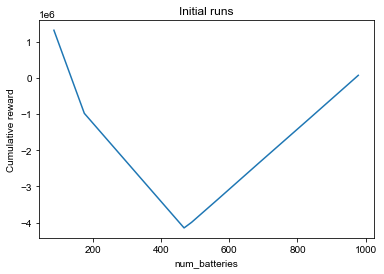

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
100%|██████████| 3/3 [00:59<00:00, 19.77s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradi

successfully ran loop


In [8]:
# Initial set of batteries and associated reward of simulation

num_batteries = DiscreteParameter('num_batteries', [i for i in range(0, max_num_batteries)])
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

parameter_space = ParameterSpace([num_batteries])
design = RandomDesign(parameter_space)

successful_sample = False
num_tries = 0
max_num_tries = 3

use_default= False
use_ard=False

while not successful_sample and num_tries < max_num_tries: 
    
    print(f"CURRENT ATTEMPT #{num_tries}")
    
    X = design.get_samples(num_data_points)
    Y = f_multiprocess(X)
    
    # plot init values
    order = X.argsort(axis=0)
    init_X = X[order].flatten().reshape(-1, 1)
    init_Y = Y[order].flatten().reshape(-1, 1)
    plt.plot(init_X, init_Y)
    plt.style.use('seaborn')
    plt.title("Initial runs")
    plt.xlabel(parameter_space.parameters[0].name)
    plt.ylabel("Cumulative reward")
    plt.show()
    
    # emulator model

    if use_default: 
        gpy_model = GPRegression(X, Y)
    else: 
        kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
        gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
    
    try: 
        gpy_model.optimize()
        print("okay to optimize")
        model_emukit = GPyModelWrapper(gpy_model)

        # Load core elements for Bayesian optimization
        expected_improvement = ExpectedImprovement(model=model_emukit)
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                 space=parameter_space,
                                                 acquisition=expected_improvement,
                                                 batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = (
            FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
        )

        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        print("successfully ran loop")
        successful_sample = True
        
    except: 
        num_tries += 1 


In [9]:
X.flatten(), Y.flatten()

(array([950, 832, 567, 739, 686, 468, 490, 176,  87, 978]),
 array([ -165209.64525114, -1149911.98228311, -3354522.93739726,
        -1920653.70892694, -2360445.61394978, -4145516.95253425,
        -3991229.6213927 ,  -980427.86586758,  1314672.20815068,
           69439.63938356]))

In [10]:
# Visualize and get extrema
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

In [11]:
order = new_X.argsort(axis=0)
new_X[order].flatten(), new_Y[order].flatten()

(array([ 87., 176., 366., 366., 366., 394., 394., 394., 468., 490., 567.,
        686., 739., 832., 950., 978.]),
 array([ 1314672.20815068,  -980427.86586758, -4386210.96691781,
        -4386210.96691781, -4386210.96691781, -4541682.60728311,
        -4541682.60728311, -4541682.60728311, -4145516.95253425,
        -3991229.6213927 , -3354522.93739726, -2360445.61394978,
        -1920653.70892694, -1149911.98228311,  -165209.64525114,
           69439.63938356]))

In [12]:
new_X = new_X[order].flatten().reshape(-1, 1)
new_Y = new_Y[order].flatten().reshape(-1, 1)

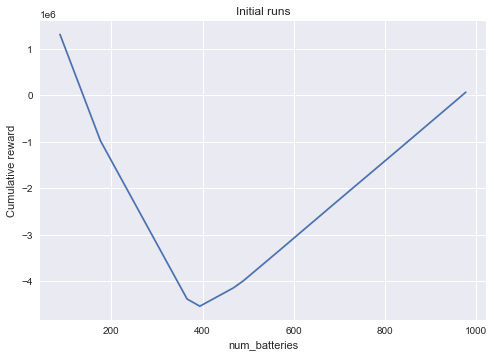

In [13]:
plt.plot(new_X, new_Y)
plt.style.use('seaborn')
plt.title("Initial runs")
plt.xlabel(parameter_space.parameters[0].name)
plt.ylabel("Cumulative reward")
plt.show()

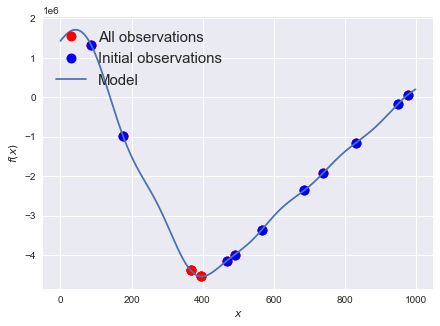

In [16]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

# plt.figure(figsize=(12, 8))
plt.figure(figsize=(7, 5))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()

In [15]:
num_tries

0

In [ ]:

# X = design.get_samples(num_data_points)
# Y = f(X)


In [ ]:
# # emulator model
# use_default= False
# use_ard=True
# if use_default: 
#     gpy_model = GPRegression(X, Y)
# else: 
#     kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
#     gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
# gpy_model.optimize()
# model_emukit = GPyModelWrapper(gpy_model)

In [ ]:
# # Load core elements for Bayesian optimization
# expected_improvement = ExpectedImprovement(model=model_emukit)
# optimizer = GradientAcquisitionOptimizer(space=parameter_space)

In [ ]:
# # Create the Bayesian optimization object
# batch_size = 3
# bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
#                                          space=parameter_space,
#                                          acquisition=expected_improvement,
#                                          batch_size=batch_size)


In [ ]:
# # Run the loop and extract the optimum;  we either complete 10 steps or converge
# max_iters = 10
# stopping_condition = FixedIterationsStoppingCondition(
#     i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)

# bayesopt_loop.run_loop(f, stopping_condition)